In [56]:
import os
import numpy as np
from PIL import Image
import json
import matplotlib.pyplot as plt
from os.path import join

In [57]:
def read_file(filename):
    with open(filename) as img_data:
        labels = json.load(img_data)['objects']
        return labels

In [58]:
def find_center(polygon):
    return [x_center(polygon), y_center(polygon)]

In [59]:
def x_center(polygon):
    min_x = min(list(map(lambda p: p[0], polygon)))
    max_x = max(list(map(lambda p: p[0], polygon)))
    return min_x + (max_x - min_x) // 2

In [60]:
def y_center(polygon):
    min_y = min(list(map(lambda p: p[1], polygon)))
    max_y = max(list(map(lambda p: p[1], polygon)))
    return min_y + (max_y - min_y) // 2

In [61]:
def classify_pixels(labels):
    traffic_lights = list(filter(lambda label: label['label'] == 'traffic light', labels))
    traffic_lights = list(map(lambda t: t['polygon'], traffic_lights))
    traffic_lights = list(map(find_center, traffic_lights))
    non_traffic_lights = n_random_pixels(labels, len(traffic_lights))
    return traffic_lights, non_traffic_lights

In [62]:
def n_random_pixels(labels, n):
    random_labels = list(filter(lambda label: label['label'] != 'traffic light', labels))
    all_random_pixels = np.concatenate([l['polygon'] for l in random_labels])
    random_indices = np.random.choice(len(all_random_pixels), n, replace=False)
    return all_random_pixels[random_indices]

In [63]:
def deal_with_edge_cases(center_index, image, size=81):
    half_size = size // 2
    zeros_array = np.zeros((size, size, 3))
    difference_x = half_size - (center_index[0])
    difference_y = half_size - (center_index[1])
    for i in range(len(image)):
        for j in range(len(image[0])):
            zeros_array[i + difference_x][j + difference_y] = image[i][j]
    return zeros_array

In [64]:
def crop_image(img, tfl_pixels, not_tfl_pixels):
    images = []
    # not_tfl_pixels.append([0, 0])
    labels = [1] * len(tfl_pixels) + [0] * len(not_tfl_pixels)
    im = np.asarray(Image.open(img))


    for pixel in tfl_pixels + list(not_tfl_pixels):
        left = max(0, pixel[0] - 40)
        right = min(2048, pixel[0] + 40)
        top = max(0, pixel[1] - 40)
        bottom = min(1024, pixel[1] + 40)
        cropped = im[top:bottom + 1, left:right + 1, :]
        width, height = cropped.shape[:2]
        if width < 81 or height < 81:
            new_pixel = (pixel[0] - top, pixel[1] - left)
            cropped = deal_with_edge_cases(new_pixel[::-1], cropped)
        images.append(cropped)
    return images, labels

In [65]:
def convert_to_bin(image,img_name,is_bin):
    image = np.asarray(image, dtype=np.uint8)

    with open(f'{img_name}.bin', 'ab') as labels_bin:
        for im in image:
            try:
                labels_bin.write(im.tobytes())
            except:
                labels_bin.write(im.to_bytes(1, "little"))

In [66]:
def create_bin_files(images, labels, path):
    try:
        os.makedirs(path)
    except FileExistsError:
        pass
    convert_to_bin(images, f"{path}/data", False)
    convert_to_bin(labels, f"{path}/labels",True)

In [67]:
file = './gtFine/val/frankfurt/frankfurt_000000_011007_gtFine_polygons.json'
img = './leftImg8bit/val/frankfurt/frankfurt_000000_011007_leftImg8bit.png'
tfl_pixels, not_tfl_pixels = classify_pixels(read_file(file))
create_bin_files(*crop_image(img, tfl_pixels, not_tfl_pixels), "Data_dir/val")

file = './gtFine/train/aachen/aachen_000001_000019_gtFine_polygons.json'
img = './leftImg8bit/train/aachen/aachen_000001_000019_leftImg8bit.png'
tfl_pixels, not_tfl_pixels = classify_pixels(read_file(file))
create_bin_files(*crop_image(img, tfl_pixels, not_tfl_pixels), 'Data_dir/train')

In [68]:
def load_tfl_data(data_dir, crop_shape=(81, 81)):
    images = np.memmap(join(data_dir, 'data.bin'), mode='r', dtype=np.uint8).reshape([-1] + list(crop_shape) + [3])
    labels = np.memmap(join(data_dir, 'labels.bin'), mode='r', dtype=np.uint8)
    return {'images': images, 'labels': labels}

In [69]:
def viz_my_data(images, labels, predictions=None, num=(5, 5), labels2name={0: 'No TFL', 1: 'Yes TFL'}):
    assert images.shape[0] == labels.shape[0]
    assert predictions is None or predictions.shape[0] == images.shape[0]
    h = 5
    n = num[0] * num[1]
    ax = plt.subplots(num[0], num[1], figsize=(h * num[0], h * num[1]), gridspec_kw={'wspace': 0.05}, squeeze=False,
                      sharex=True, sharey=True)[1]  # .flatten()
    idxs = np.random.randint(0, images.shape[0], n)
    for i, idx in enumerate(idxs):
        ax.flatten()[i].imshow(images[idx])
        title = labels2name[labels[idx]]
        if predictions is not None: title += ' Prediction: {:.2f}'.format(predictions[idx])
        ax.flatten()[i].set_title(title)

val :  (24, 81, 81, 3) 0/1 split 50.0 %
train :  (16, 81, 81, 3) 0/1 split 50.0 %


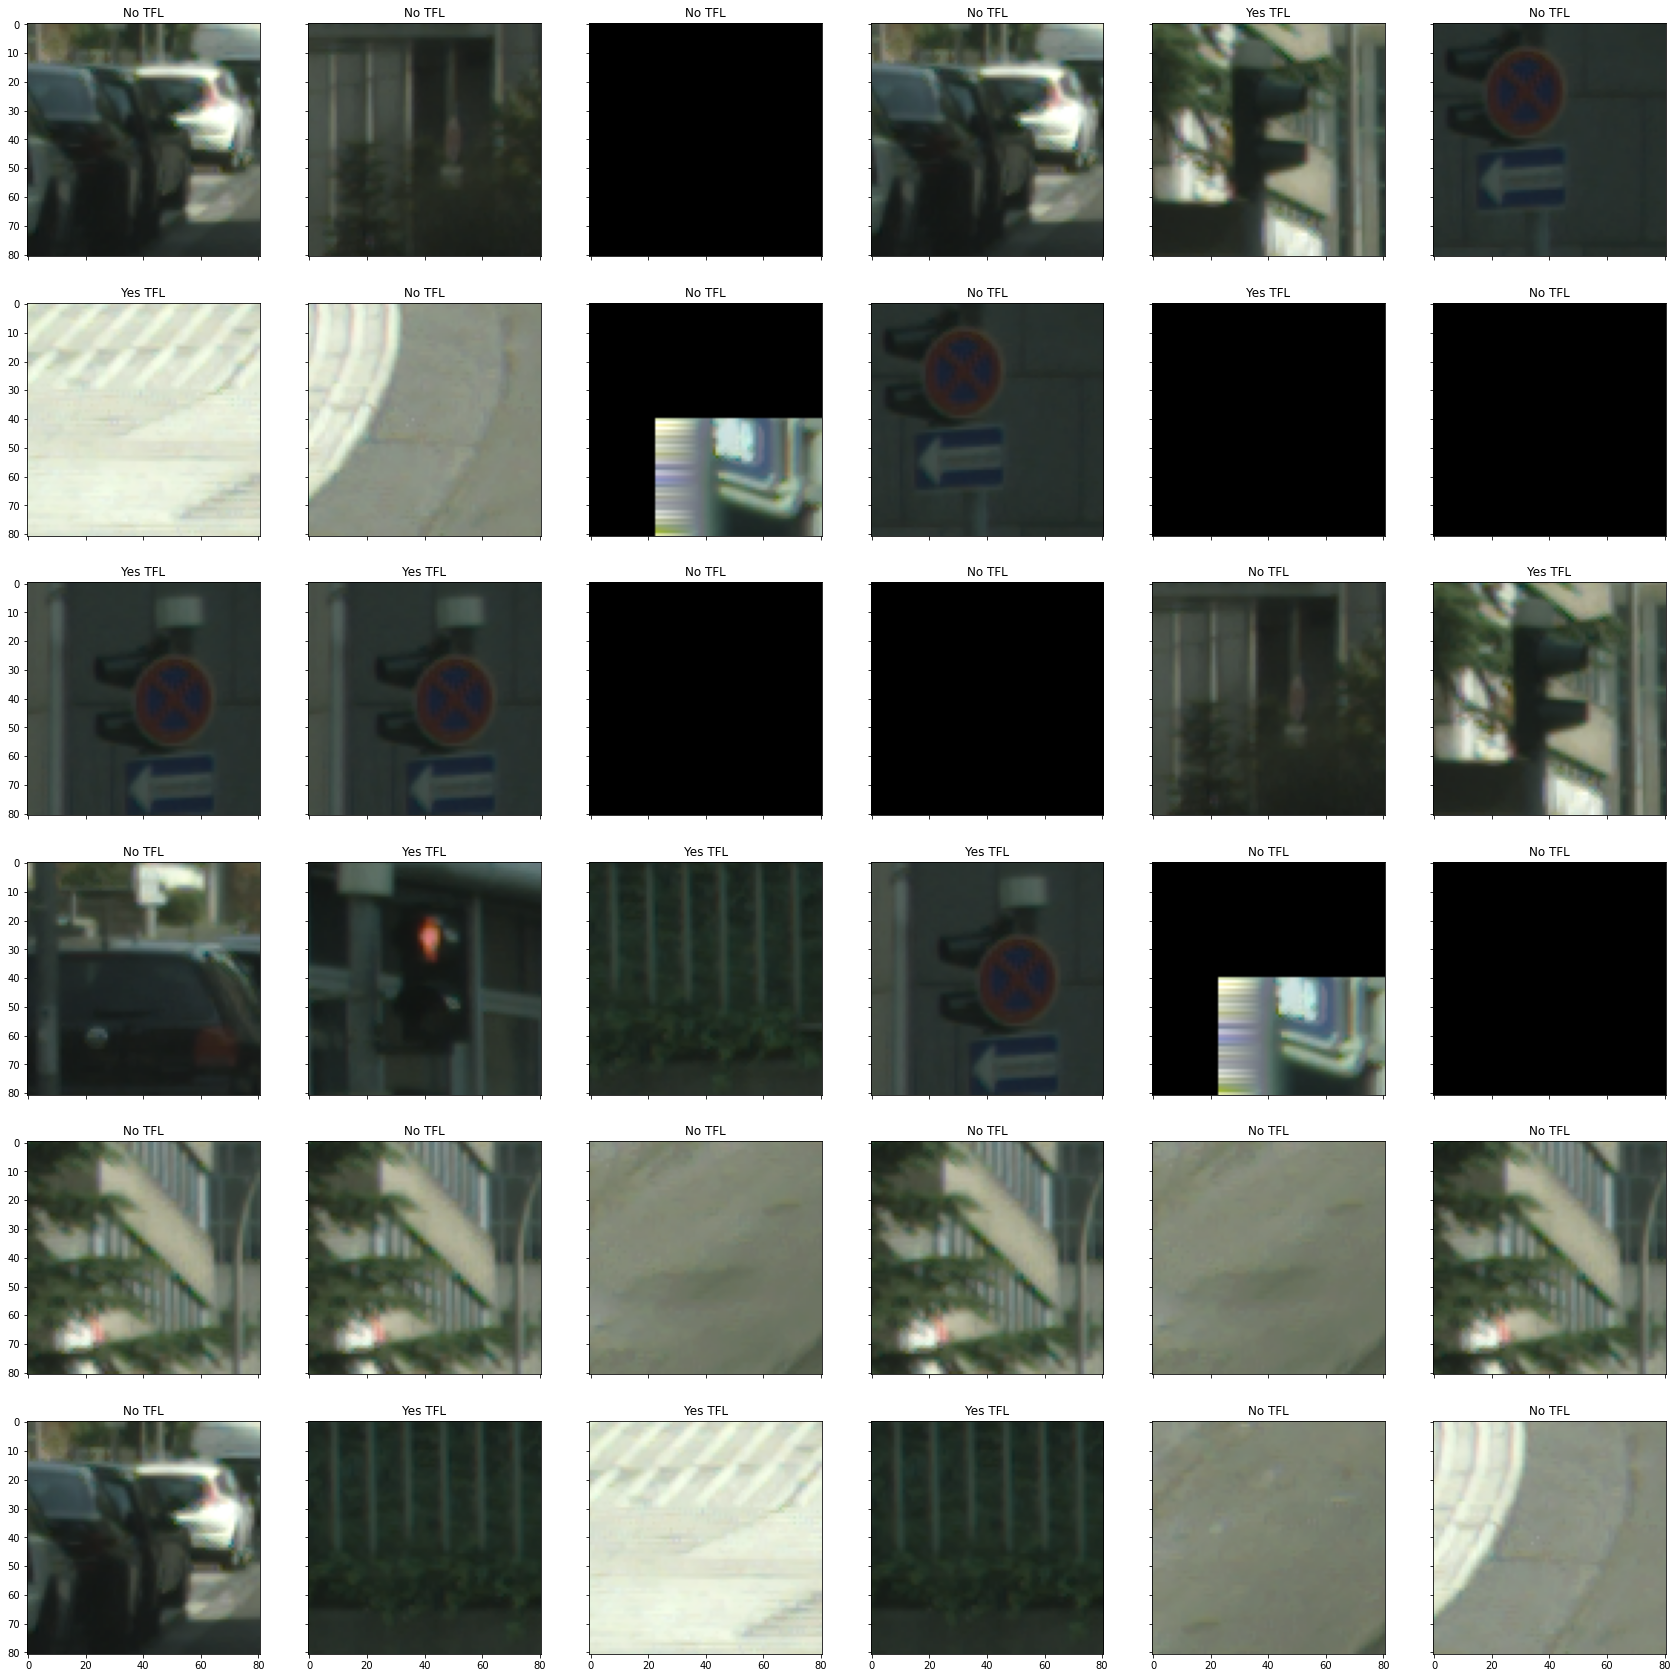

In [70]:
# root = './'  #this is the root for your val and train datasets
data_dir = './Data_dir/'
datasets = {
    'val': load_tfl_data(join(data_dir, 'val')),
    'train': load_tfl_data(join(data_dir, 'train')),
}
for k, v in datasets.items():
    print('{} :  {} 0/1 split {:.1f} %'.format(k, v['images'].shape, np.mean(v['labels'] == 1) * 100))
viz_my_data(num=(6, 6), **datasets['val'])